<a href="https://colab.research.google.com/github/Ghiles1010/test_SIC_9/blob/main/problem_0701.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Quiz #0701

### "TensorFlow machine learning with Calilfornia housing data"

In [28]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

import warnings
%matplotlib inline
warnings.filterwarnings('ignore')    # Turn the warnings off.

#### Answer the following question by providing Python code:

In [29]:
# Bring the data.
housing_data = fetch_california_housing()

In [30]:
# Read the description.
print(housing_data['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

1). Explore the data:
- Display the dataset as a DataFrame with column labels.

In [31]:
def load_data():
  housing_data = fetch_california_housing()
  X, Y = housing_data.data, housing_data.target
  feature_names = housing_data['feature_names'] + ['target']
  df = pd.DataFrame(data= np.c_[X, Y], columns= feature_names)

  return df

df = load_data()
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


Let's check disitrbutions of the data

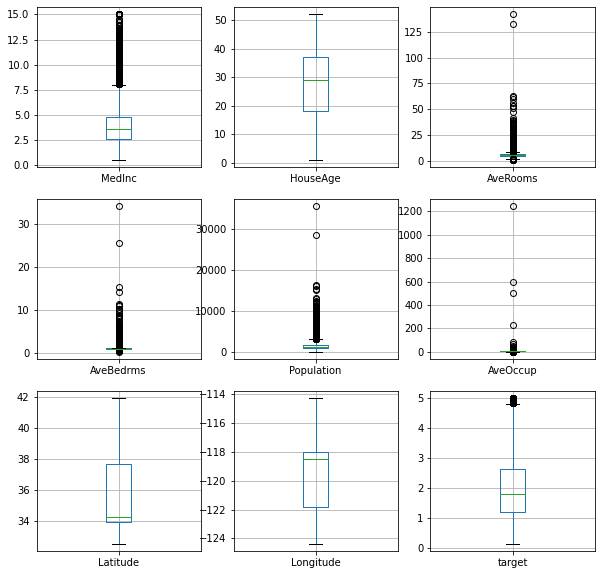

In [32]:
import matplotlib.pyplot as plt

r, c = 3, 3
fig, ax = plt.subplots(r, c)

fig.set_figwidth(10)
fig.set_figheight(10)

ax = ax.ravel()
for idx, column in enumerate(df.columns):
  df.boxplot(column = column, ax=ax[idx]) 

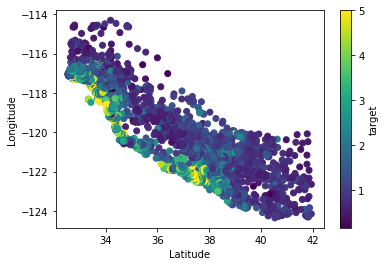

In [33]:
plt.scatter(x=df['Latitude'], y=df['Longitude'], c=df['target'])
plt.rcParams["figure.figsize"] = (7,7)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
cbar = plt.colorbar()
cbar.set_label("target")

We can see that houses with lower latitude and higher longitude have higher target values

In [34]:
df.isnull().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
target        0
dtype: int64

No missing values

2). Build a machine learning model with TensorFlow. 
- Preprocess the data if necessary.
- Build a linear regression model.
- Train the model.
- Calculate the error metrics such as MSE and RMSE (in-sample and out-of-sample). Target: RMSE < 1.

# Preprocess

We'll do the following scalings :

<ul>
  <li><b>We will use Robust scaling for the data suffering from extreme outliers:</b></li>
  Avgrooms - avgBedrms - Population - AveOccup - medInc<br/>
  The formula is : 
  $$ \frac{x-median}{Q_{25} - Q_{75}}$$
  so that outliers dont affect that much
  <li><b>We will use Standard scaling for :</b></li>
  - Target<br/>
  - houseAge
  <li><b>We will use Min MAX scaling for :</b></li>
  - Latitude<br/>
  - Longitude

<ul/>


In [35]:
df.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'target'],
      dtype='object')

In [36]:
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

# reload data in case we re-run this
df = load_data()

# Robust
robust_columns = ["MedInc", "AveRooms", "AveBedrms", "Population", "AveOccup"]

scaler = RobustScaler()
df[robust_columns] = scaler.fit_transform(df[robust_columns])

# Standard
standard_columns = ["HouseAge", "target"]

scaler = StandardScaler()
df[standard_columns] = scaler.fit_transform(df[standard_columns])

# MinMax
minmax_columns=["Latitude", "Longitude"]

scaler = MinMaxScaler()
df[minmax_columns] = scaler.fit_transform(df[minmax_columns])


In [37]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,2.197582,0.982143,1.088935,-0.267221,-0.899787,-0.307981,0.567481,0.211155,2.129631
1,2.186664,-0.607019,0.626066,-0.822926,1.316631,-0.830800,0.565356,0.212151,1.314156
2,1.707732,1.856182,1.898042,0.263955,-0.714286,-0.018599,0.564293,0.210159,1.258693
3,0.967177,1.856182,0.364978,0.259814,-0.648188,-0.316908,0.564293,0.209163,1.165100
4,0.142854,1.856182,0.653191,0.345657,-0.640725,-0.746784,0.564293,0.209163,1.172900


In [38]:
from sklearn.model_selection import train_test_split

X = df.drop('target', axis = 1)
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.3, random_state=3)

In [39]:
print(X_train.shape)
print(y_train.shape)

(14448, 8)
(14448,)


# Build Model

In [40]:
#init weights ad biases with ones
W = tf.Variable(tf.random.normal([9]))                 

In [41]:
#def placeholders
X_ph = tf.placeholder(tf.float32, shape=(14448, 9), name="X_ph")   
y_ph = tf.placeholder(tf.float32, shape=(14448, 1), name = "y_ph")           

In [42]:
X_ph.shape

TensorShape([14448, 9])

In [43]:
W.shape

TensorShape([9])

In [44]:
# Model.
y_model = tf.tensordot(X_ph, W, axes=[1,0])

In [45]:
loss = tf.reduce_mean(tf.square(y_ph - y_model)) 
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)     
n_epochs = 10000                                          # N# of epochs (gradient descent steps).
train = optimizer.minimize(loss)                         # Define training.
init = tf.global_variables_initializer()  

In [46]:
n, m = X_train.shape
X_train.shape

(14448, 8)

In [47]:
X_train_bias=np.c_[np.ones((n,1)), X_train]
X_train_bias.shape

(14448, 9)

In [48]:
y_train.shape

(14448,)

In [49]:
#Training

with tf.Session() as sess:
        # Variables initialization.
        sess.run(init)
        # Training.
        my_feed = {X_ph:X_train_bias, y_ph:y_train.reshape(-1,1)}                        # Prepare feed data as a dictionary. 
        for i in range(n_epochs):
            sess.run(train, feed_dict = my_feed)
            if ((i % 500) == 0):print(i)
        W = sess.run(W)                   # Get the final values of the Variables.
        # Testing.
        
        mse_value = sess.run(loss, feed_dict = my_feed)   

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500


In [53]:
rmse = np.sqrt(mse_value)

print("RMSE =", rmse)

RMSE = 1.0055038
